# SCC0270 - Trabalho 02 - Multimodalidade

In [ ]:
# 1. MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [ ]:
base_path = '/content/drive/MyDrive/BECD/SCC0270-2025-01/MedPix-2.0'
train_json_path = f'{base_path}/splitted_dataset/descriptions_train.jsonl'
test_json_path  = f'{base_path}/splitted_dataset/descriptions_test.jsonl'
images_dir      = f'{base_path}/images/'

In [ ]:
# --- Load CLIP ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# --- Dataset ---
class MedPixCLIPDataset(Dataset):
    def __init__(self, json_path, image_dir, clip_processor, label_encoder=None, is_train=True):
        self.image_dir = image_dir
        self.processor = clip_processor
        self.data = []
        with open(train_json_path, 'r') as f:
            for line in f:
                item = json.loads(line)
                if not item.get('Description').get("Caption") or not item.get("Location"):
                    continue
                self.data.append({
                    "image": item["image"] + ".png",
                    "caption": item["Description"]["Caption"],
                    "location": item["Location"]
                })

        self.labels = [item["location"] for item in self.data]
        if label_encoder is None and is_train:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)
        else:
            self.label_encoder = label_encoder

        self.label_ids = self.label_encoder.transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.image_dir, item["image"])
        image = Image.open(image_path).convert('RGB')
        caption = item["caption"]

        return {
            "image": image,
            "text": caption,
            "label": torch.tensor(self.label_ids[idx])
        }

In [ ]:
def custom_collate_fn(batch):
    images = [item['image'] for item in batch]
    texts = [item['text'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    return {"image": images, "text": texts, "label": labels}

In [ ]:
# --- Load Data ---
train_dataset = MedPixCLIPDataset(train_json_path, images_dir, clip_processor)
test_dataset = MedPixCLIPDataset(test_json_path, images_dir, clip_processor, label_encoder=train_dataset.label_encoder, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)
num_classes = len(train_dataset.label_encoder.classes_)

In [ ]:
# --- Classifier on top of CLIP embeddings ---
class CLIPClassifier(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, image_features, text_features):
        x = torch.cat([image_features, text_features], dim=1)
        return self.classifier(x)

model = CLIPClassifier(embed_dim=512, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# --- Training ---

#Guarda losses para varificação
train_loss = []
eval_loss = []

EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0
    total_eval_loss = 0.0

    for batch in train_loader:
        inputs = clip_processor(text=batch["text"], images=batch["image"], return_tensors="pt", padding=True, truncation=True).to(device)
        labels = batch["label"].to(device)

        with torch.no_grad():
            clip_outputs = clip_model(**inputs)
            image_feats = clip_outputs.image_embeds #image_embeddings
            text_feats = clip_outputs.text_embeds #text_embeddings

        #Normalização L2 - Vetores passam a ser unitários

        '''
        Importante lembrar que durante o cálculo dos gradientes pelo otimizador,
        os produtos internos nada mais do que são a similaridade de cossenos, pois
        os vetores já foram normalizados.
        '''

        image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

        outputs = model(image_feats, text_feats)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    # --- Evaluation ---
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
      for batch in test_loader:
        inputs = clip_processor(text=batch["text"], images=batch["image"], return_tensors="pt", padding=True, truncation=True).to(device)
        eval_labels = batch["label"].to(device)

        clip_outputs = clip_model(**inputs)
        eval_image_feats = clip_outputs.image_embeds
        eval_text_feats = clip_outputs.text_embeds

        eval_image_feats = eval_image_feats / eval_image_feats.norm(dim=-1, keepdim=True)
        eval_text_feats = eval_text_feats / eval_text_feats.norm(dim=-1, keepdim=True)

        outputs = model(eval_image_feats, eval_text_feats)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(eval_labels.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

        loss = criterion(outputs, eval_labels)
        total_eval_loss += loss.item()

      avg_eval_loss = total_eval_loss / len(test_loader)
      eval_loss.append(avg_eval_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_eval_loss:.4f}")

[Epoch 1] Train Loss: 2.7800 | Validation Loss: 2.4204
[Epoch 2] Train Loss: 2.2052 | Validation Loss: 2.0617
[Epoch 3] Train Loss: 1.9591 | Validation Loss: 1.8631
[Epoch 4] Train Loss: 1.7838 | Validation Loss: 1.7097
[Epoch 5] Train Loss: 1.6513 | Validation Loss: 1.6022
[Epoch 6] Train Loss: 1.5533 | Validation Loss: 1.5175
[Epoch 7] Train Loss: 1.4880 | Validation Loss: 1.4519
[Epoch 8] Train Loss: 1.4316 | Validation Loss: 1.3922
[Epoch 9] Train Loss: 1.3689 | Validation Loss: 1.3451
[Epoch 10] Train Loss: 1.3309 | Validation Loss: 1.3012
[Epoch 11] Train Loss: 1.2857 | Validation Loss: 1.2629
[Epoch 12] Train Loss: 1.2505 | Validation Loss: 1.2265
[Epoch 13] Train Loss: 1.2103 | Validation Loss: 1.1933
[Epoch 14] Train Loss: 1.1796 | Validation Loss: 1.1615
[Epoch 15] Train Loss: 1.1538 | Validation Loss: 1.1329
[Epoch 16] Train Loss: 1.1215 | Validation Loss: 1.1054
[Epoch 17] Train Loss: 1.0937 | Validation Loss: 1.0766
[Epoch 18] Train Loss: 1.0707 | Validation Loss: 1.0504
[

In [ ]:
print(classification_report(y_true, y_pred, target_names=train_dataset.label_encoder.classes_))

                        precision    recall  f1-score   support

               Abdomen       1.00      0.10      0.17        42
          Bethesda, MD       0.00      0.00      0.00         2
       Brain and Neuro       0.80      0.97      0.88       522
Breast and Mammography       0.00      0.00      0.00         9
        Cardiovascular       0.89      0.66      0.76        50
      Chest, Pulmonary       0.79      0.95      0.86       187
Dental, Oral, or Tooth       0.00      0.00      0.00         1
             Endocrine       0.00      0.00      0.00         4
         Eye and Orbit       0.88      0.57      0.69        49
      Gastrointestinal       0.65      0.95      0.77       154
           Generalized       1.00      0.11      0.19        56
         Genitourinary       0.71      0.83      0.77       120
         Head and Neck       0.77      0.58      0.66        76
         Hematopoietic       0.00      0.00      0.00         6
       Musculoskeletal       0.85      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


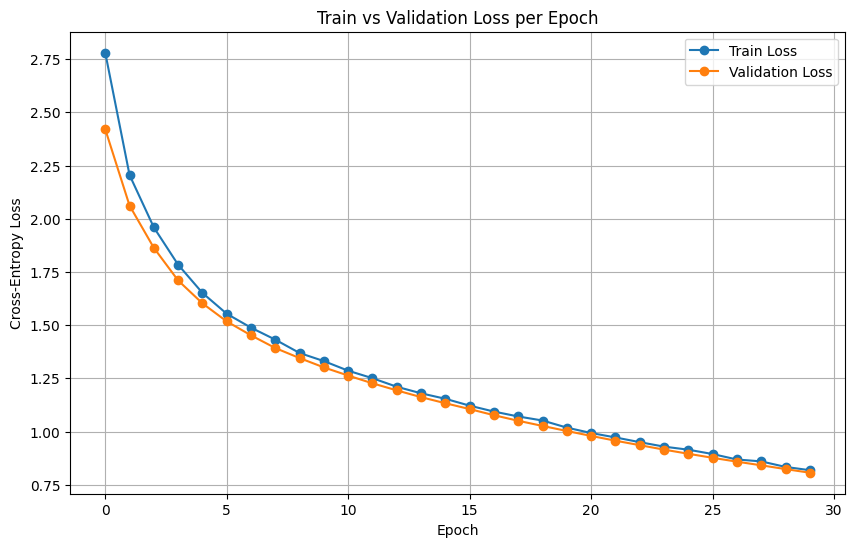

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss", marker='o')
plt.plot(eval_loss, label="Validation Loss", marker='o')
plt.title("Train vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

O modelo parece não estar em *overfitting* com 30 *epochs*. Dito isso, poderíamos aumentar o número de épocas e obter resultados ainda melhores, porém, decidimos parar com 30 épocas.

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': train_dataset.label_encoder.classes_
}, "/content/drive/MyDrive/BECD/SCC0270-2025-01/MedPix-2.0/clip_multimodal_classifier.pth")